# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span>
 Remember to check that it says the exact commit you should be working on </br>
 ### *This only needs to be run once, then the folder will be created*

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
!git checkout d9f785b
%pip install .

[Errno 2] No such file or directory: 'susceptibility-to-fieldmap-fft'
/Users/soothsayer7/msc_rios/sus-optimization/susceptibility-to-fieldmap-fft
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Note: switching to 'd9f785b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at d9f785b Fix bug
Processing /Users/soothsayer7/msc_rios/sus-optimization/susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'susceptibility-to-field

In [3]:
home_path = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt
chi_opt_demod_32.ipynb
chi_opt_demod_33.ipynb
chi_opt_demod_35.ipynb
demod.py
fresita_opt.py
shazam_requirements.txt
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [4]:
path_to_chi_to_fm_fft = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

In [5]:
#Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# This function is only useful if you want to print and display while optimizing
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

 # <span style="color:silver"> *Data analysis* </span> 

In [6]:
# Define the run nfolder name
run_number = "test1_powell"

In [7]:
# Everytime you run the code, it will create a new folder with the run number and restart the counter
path_to_iter_fms = r"E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms"
path_to_iter_metrics = r"E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics"

path_to_iter_fms = os.path.join(path_to_iter_fms,run_number)
path_to_iter_metrics = os.path.join(path_to_iter_metrics,run_number)
counter = 0

#########
# This don't change, this are used with the simulation's FOV
path_to_sim_metric_mask = "E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:\msc_data/ismrm_2025/dB0_035/fm/sim/B1_chi_maps/dB0_035_abs_chi_dist.nii.gz" # -4.36 (past value)
path_to_segs = r"E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\final_merged_wb_segs.nii.gz"


##  <span style="color:#C133FF"> *Performing demodulation on measured!* </span> 

In [8]:
import importlib
import utils.demod   # your custom module (e.g., my_module.py)
importlib.reload(utils.demod)
from utils.demod import demod_Hz

In [9]:
# load it:
db0_035_avg_dmod_metric_values_df = pd.read_csv(r"E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\dB0_035_avg_dmod_meas_metrics_c3t7.csv")

In [10]:
# Check the values:
db0_035_avg_dmod_metric_values = db0_035_avg_dmod_metric_values_df['WA()']
db0_035_avg_dmod_metric_values

0    -76.198194
1    -86.727411
2    -74.811855
3    -36.277499
4     23.813495
5     82.638355
6     72.294822
7     48.810360
8     45.322720
9     58.677333
10    59.936366
11    22.478234
Name: WA(), dtype: float64

In [11]:
central_freq_exp_db35 = 123.249391 # in MHz
gamma_bar = 42.58 # MHz/T
B0 = 3 # [T]
B0_used_scanner = central_freq_exp_db35 /gamma_bar
print("The B0 to use in the simulation should be: ", B0_used_scanner, "T")


The B0 to use in the simulation should be:  2.894537130108032 T


### <span style="color:chocolate"> *In case you want to compare in a plot!* </span> 

In [14]:
# Load simulation
path_to_zero_ref_metrics = "E:/msc_data/ismrm_2025/dB0_035/fm/sim/D4_metrics/abs_sim_fm_ppm.csv"
zero_ref_dB0_035_sim_ppm = pd.read_csv(path_to_zero_ref_metrics)
zero_ref_dB0_035_sim_ppm = zero_ref_dB0_035_sim_ppm["WA()"][::-1]
zero_ref_dB0_035_sim_ppm

10   -2.996466
9    -2.952861
8    -2.736799
7    -2.498675
6    -2.222258
5    -2.239622
4    -2.387479
3    -2.448192
2    -2.402835
1    -2.314481
0    -2.365177
Name: WA(), dtype: float64

In [15]:
# Demodulate with SC average and plot
db0_035_sim_dmod_value = zero_ref_dB0_035_sim_ppm.mean()
print("Demodulation for simulation using SC average with value: ", db0_035_sim_dmod_value)

Demodulation for simulation using SC average with value:  -2.5058951085491716


In [16]:
# Demodulate and plot:
demod_dB0_035_sim_ppm = zero_ref_dB0_035_sim_ppm - db0_035_sim_dmod_value


In [17]:
demod_dB0_035_sim_Hz = demod_dB0_035_sim_ppm * central_freq_exp_db35
demod_dB0_035_sim_Hz

10   -60.462558
9    -55.088311
8    -28.458816
7      0.889820
6     34.958116
5     32.817999
4     14.594688
3      7.111915
2     12.702059
1     23.591721
0     17.343367
Name: WA(), dtype: float64

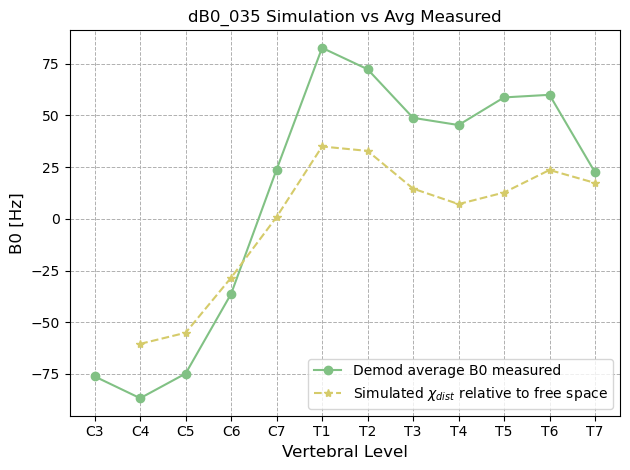

In [51]:
# With that done we can plot them:
vertebrae_levels_meas = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 3:14
vertebrae_levels_sim = ['C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6','T7'] # From 4:14
plt.plot(vertebrae_levels_meas, db0_035_avg_dmod_metric_values, marker = 'o', linestyle = '-', label = "Demod average B0 measured", color = "#81C184")
plt.plot(vertebrae_levels_sim, demod_dB0_035_sim_Hz, marker = '*', linestyle = '--', label = r"Simulated $\chi_{dist}$ relative to free space", color = "#D5CB6A")

title = "dB0_035 Simulation vs Avg Measured"
plt.title(title)
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

#yticks = range(-450, 450, 100) 
#plt.yticks(yticks)

# Show the plot
plt.show()

 # <span style="color:gold"> *Optimization loop!* </span> </br>
 With the graphs working as we expect them too, lets begin chi optimization

In [12]:
history = [] 
history_chi_trachea = []
history_chi_lungs = []

In [19]:
# Loading dependencies outside obj. function to decrease computational needs

# Load the simulated susceptibility map in ppm
sim_chi_img = nib.load(path_to_chimap)
sim_chi_data = sim_chi_img.get_fdata()

# Load segmentation labels that create the chimaps
ROI_img = nib.load(path_to_segs)
ROI_data = ROI_img.get_fdata()

# Find indices with the labels we want to update
ind_trachea = np.where((ROI_data == 8))
ind_lungs = np.where((ROI_data == 7))
#ind_body = np.where((ROI_data == 2))
#ind_bone = np.where((ROI_data == 3))

dmod_sim_mask = nib.load(path_to_dmod_mask).get_fdata()

vertebrae_levels_opt =  ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 3 to 14

In [14]:
def f_simple_double_opt(x):

    global counter # This works? 
    
    counter += 1  
    print('$$$$$$$$$$$$$$$$$$$$$$$$$')
    print(f"Iteration #{counter}")
    print(f"Chi for trachea: {x[0]}")
    print(f"Chi for lungs: {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")
    
    # Assign variables 
    # Now we get only 1 value 
    chi_internal_air = 0.27 # ppm in SI units 
    chi_trachea = x[0]
    chi_lungs = x[1]

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50) #, mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * central_freq_exp_db35
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    #chi_3_name = str(str(float(f"{chi_internal_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    #chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    #path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    #chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    #chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    #nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################
    sim_b0_Hz_name = f"sim_dmod_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    iter_fm_save_dir = os.path.join(path_to_iter_fms, sim_b0_Hz_name)
    # Now before saving the new fieldmap, lets demodulate with the SC mask
    iter_demod_value = np.mean(sim_b0_Hz[dmod_sim_mask==1])
    print(f"For iteration #{counter} using {iter_demod_value}")
    demod_iter_fm_Hz = sim_b0_Hz - iter_demod_value

    sim_b0_Hz_img = nib.Nifti1Image(demod_iter_fm_Hz, affine = sim_chi_img.affine )
    nib.save(sim_b0_Hz_img, iter_fm_save_dir)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_dmod_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics, metrics_name)
    vert_lvls = "3:14"
    extract_metrics(iter_fm_save_dir, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method = 'wa', vert = vert_lvls)

    metric_values = pd.read_csv(path_to_out_metrics)
    sim_fm_vert_values = metric_values['WA()'][::-1]
    
    # This is a test to see if chi value changes

    #crop_sim_values = dmod_sim_vert_values.iloc[[0,4,7]].values
    #print("### Sim Cropped:")
    #print(crop_sim_values)
    #print(type(crop_sim_values))
    #crop_meas_values = avg_resp_b0meas_values.iloc[[0,4,7]].values


    # Dunno how to have options in the objective fucntion so this if is manual lmao
    #if norm_type == "L2":
    difference_l2 = np.linalg.norm(db0_035_avg_dmod_metric_values - sim_fm_vert_values ) # This is the L2 norm
    difference = difference_l2
    print("Difference: ", difference)

    #crop_dif =  np.linalg.norm(crop_sim_values - crop_meas_values)
    #crop_dif = np.sum(np.abs(crop_sim_values)-np.abs(crop_meas_values))
    #print("Minimizing difference - L1 Norm: ", crop_dif)
    #difference = crop_dif
    #elif norm_type == "L1":
    #difference_L1 = np.sum(np.abs(avg_resp_b0meas_values)- np.abs(dmod_sim_vert_values))
    #difference =difference_L1
    #print("Minimizing difference - L1 Norm: ", difference_L1)

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels_opt, sim_fm_vert_values, marker = 'o', linestyle = '--', label = f"Dmod Simulated", color = "#EC3838")  
    plt.plot(vertebrae_levels_opt, db0_035_avg_dmod_metric_values, marker = 'o', linestyle = '-', label = "Dmod In-vivo meas", color = "#264cff") 
    plt.title(f"$\\chi$ of trachea: {chi1_name} & Lung: {chi2_name} with Powell method")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-200, 0, 150) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()

# Trying to show convergence plot
    error = db0_035_avg_dmod_metric_values - sim_fm_vert_values
    loss = np.linalg.norm(error)
    history.append(loss)
    history_chi_trachea.append(chi_trachea)
    history_chi_lungs.append(chi_lungs)

    return difference


 # <span style="color:#1FC7AB"> *Optimization results!* </span> </br>

In [15]:
# Before running please verify your outpaths:
print(path_to_iter_fms)
print(path_to_iter_metrics)

E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell
E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell


In [22]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter

1

In [23]:
# Manually reset counter when errors interrupt the optimization run,
# Don't forget to delete the folders
counter = 0
counter

0

Creating run folders
Folders created:  E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell
$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #1
Chi for trachea: -2.0
Chi for lungs: -4.2
For iteration #1 using -296.5230619450669
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-2_0_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-2_0_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-2_0_l_-4_2_Hz.csv

Total runtime; 10.447 seconds.

Difference:  287.07544675303876


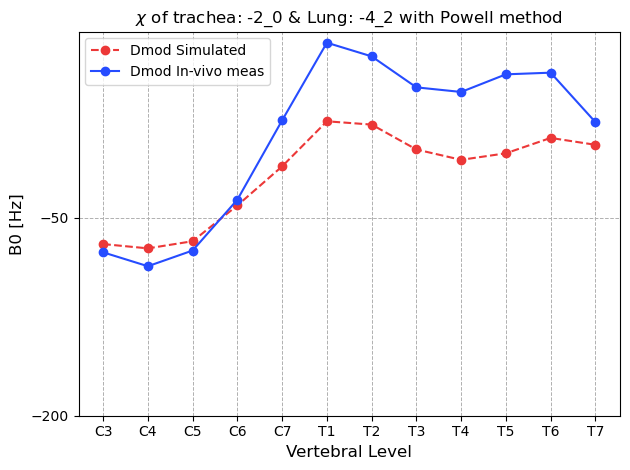

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #2
Chi for trachea: -6.721980673998823
Chi for lungs: -4.2
For iteration #2 using -296.630074413881
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-6_722_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-6_722_l_-4_2_Hz.csv

Total runtime; 9.406 seconds.

Difference:  288.36361097365454


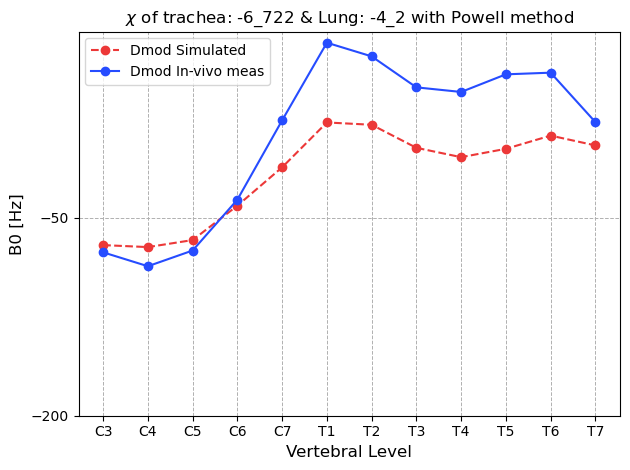

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #3
Chi for trachea: -4.078019326001179
Chi for lungs: -4.2
For iteration #3 using -296.5701553140727
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-4_078_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-4_078_l_-4_2_Hz.csv

Total runtime; 9.748 seconds.

Difference:  287.63269823073085


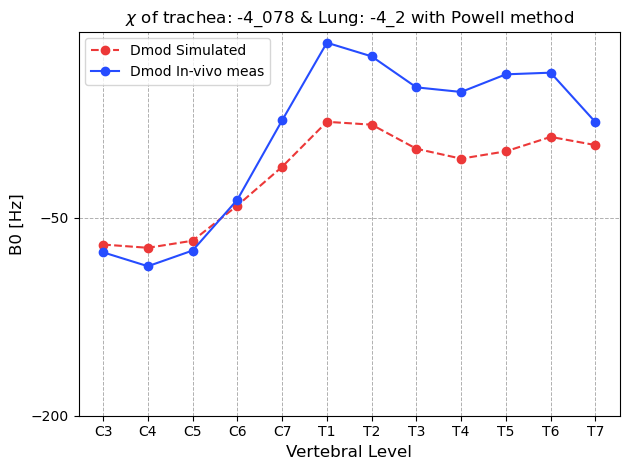

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #4
Chi for trachea: -2.4439613479976456
Chi for lungs: -4.2
For iteration #4 using -296.5331232738159
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-2_444_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-2_444_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-2_444_l_-4_2_Hz.csv

Total runtime; 9.500 seconds.

Difference:  287.19322409081303


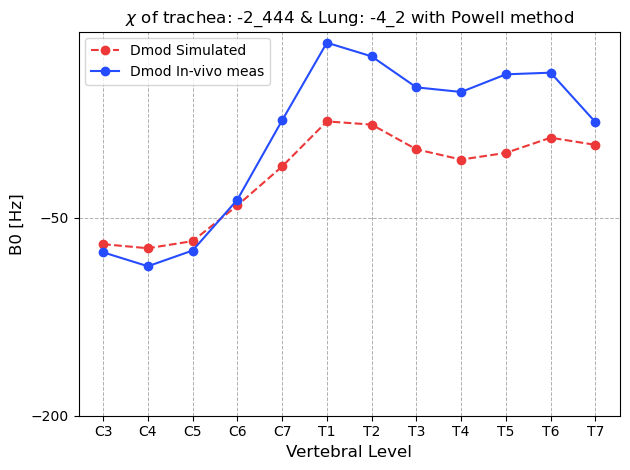

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #5
Chi for trachea: -1.4340579780035339
Chi for lungs: -4.2
For iteration #5 using -296.5102362142643
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-1_434_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-1_434_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-1_434_l_-4_2_Hz.csv

Total runtime; 9.518 seconds.

Difference:  286.9263183686228


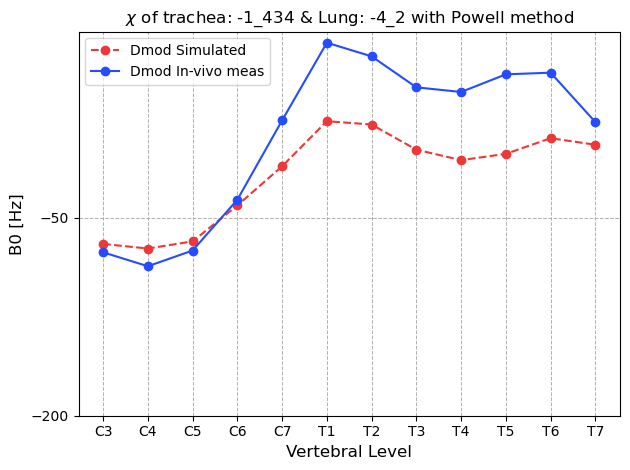

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #6
Chi for trachea: -0.809903369994112
Chi for lungs: -4.2
For iteration #6 using -296.49609123355896
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-0_81_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_81_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_81_l_-4_2_Hz.csv

Total runtime; 9.470 seconds.

Difference:  286.7631638481231


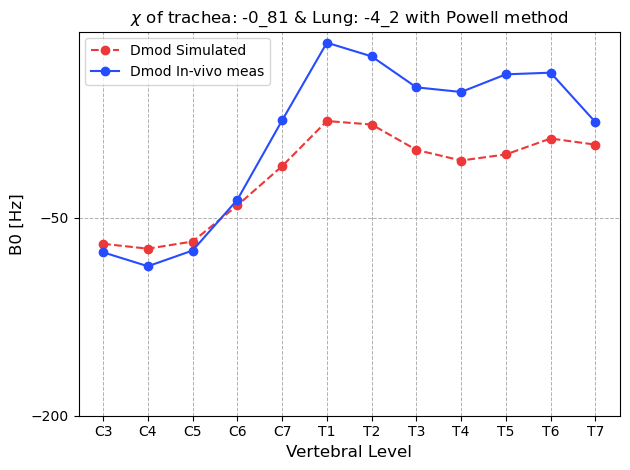

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #7
Chi for trachea: -0.42415460800942206
Chi for lungs: -4.2
For iteration #7 using -296.4873491547129
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-0_424_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_424_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_424_l_-4_2_Hz.csv

Total runtime; 9.656 seconds.

Difference:  286.6630184922449


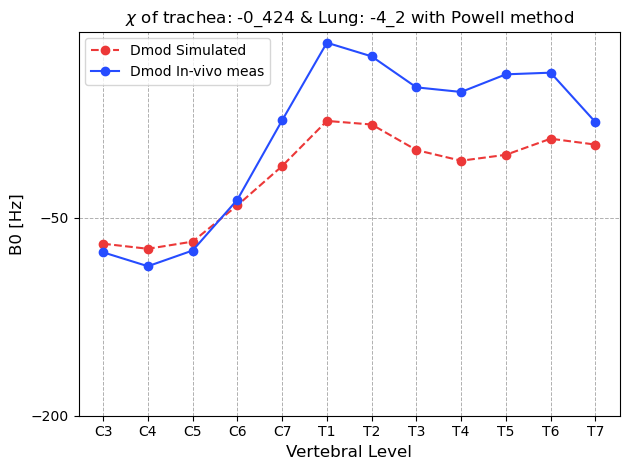

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #8
Chi for trachea: -0.18574876198469026
Chi for lungs: -4.2
For iteration #8 using -296.4819462528536
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-0_186_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_186_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_186_l_-4_2_Hz.csv

Total runtime; 9.563 seconds.

Difference:  286.6013889923151


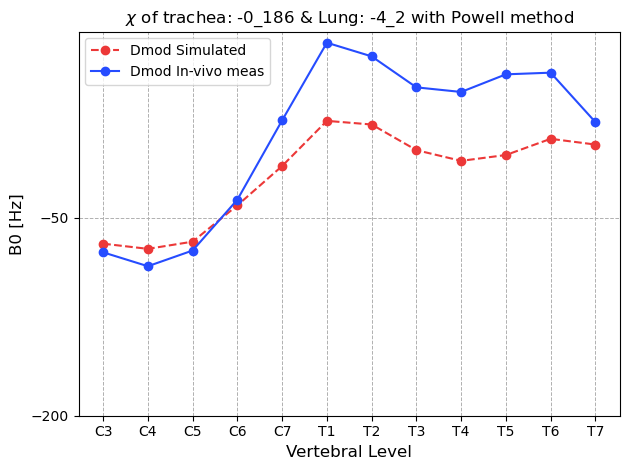

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #9
Chi for trachea: -0.03840584602473185
Chi for lungs: -4.2
For iteration #9 using -296.47860707586676
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_-0_038_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_038_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_-0_038_l_-4_2_Hz.csv

Total runtime; 9.478 seconds.

Difference:  286.56340067417


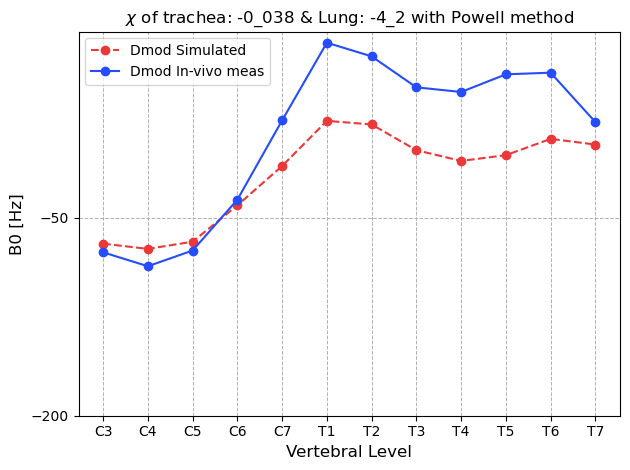

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #10
Chi for trachea: 0.052657084040041546
Chi for lungs: -4.2
For iteration #10 using -296.4765433509944
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_053_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_053_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_053_l_-4_2_Hz.csv

Total runtime; 9.428 seconds.

Difference:  286.53996112395566


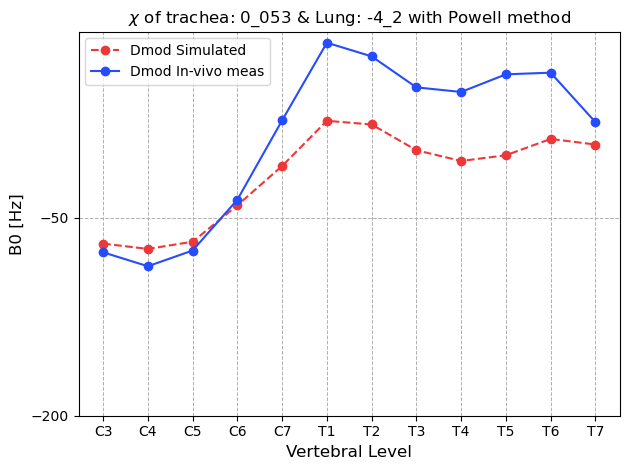

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #11
Chi for trachea: 0.10893706993522656
Chi for lungs: -4.2
For iteration #11 using -296.47526789887985
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_109_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_109_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_109_l_-4_2_Hz.csv

Total runtime; 9.504 seconds.

Difference:  286.52548940307094


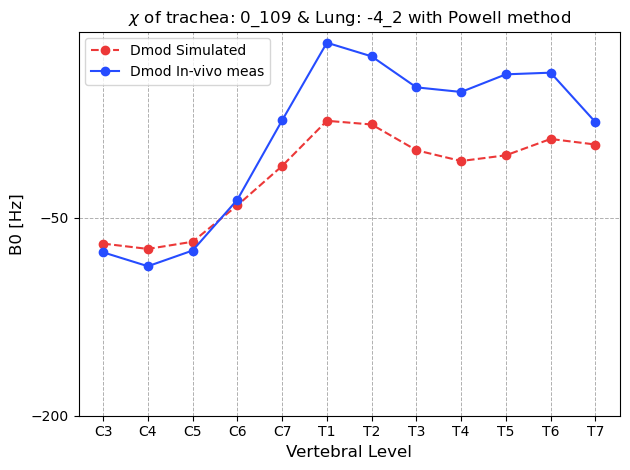

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #12
Chi for trachea: 0.1437200141048156
Chi for lungs: -4.2
For iteration #12 using -296.474479626122
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_144_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_144_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_144_l_-4_2_Hz.csv

Total runtime; 9.522 seconds.

Difference:  286.51655101031787


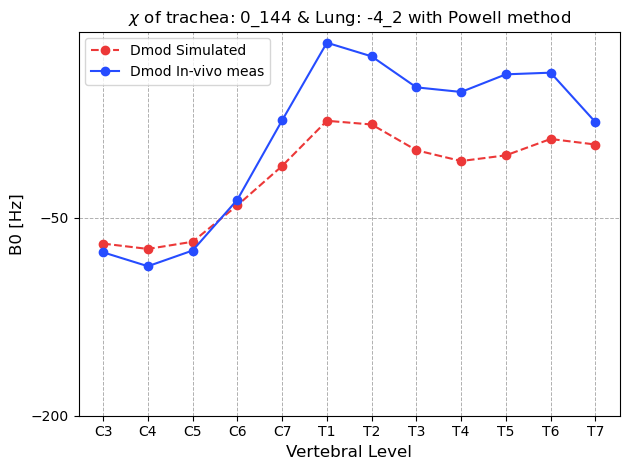

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #13
Chi for trachea: 0.16521705583041157
Chi for lungs: -4.2
For iteration #13 using -296.47399244676535
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_165_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_165_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_165_l_-4_2_Hz.csv

Total runtime; 9.520 seconds.

Difference:  286.5110289276618


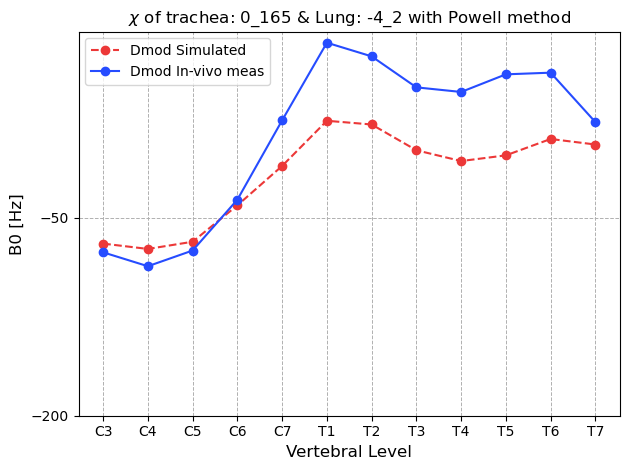

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #14
Chi for trachea: 0.17850295827440466
Chi for lungs: -4.2
For iteration #14 using -296.4736913533642
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_179_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_179_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_179_l_-4_2_Hz.csv

Total runtime; 9.583 seconds.

Difference:  286.50761691335634


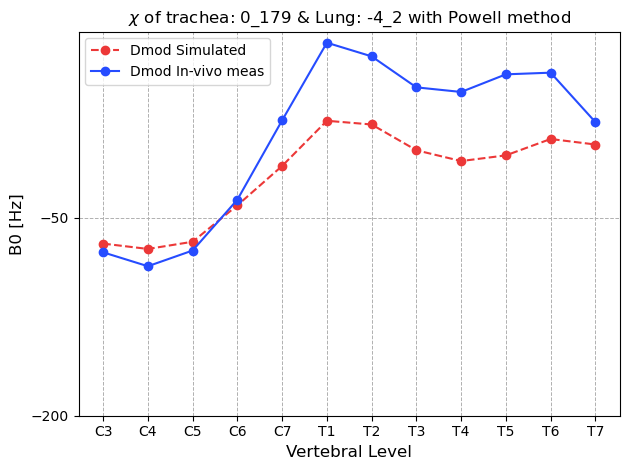

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #15
Chi for trachea: 0.18671409755600754
Chi for lungs: -4.2
For iteration #15 using -296.4735052674086
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_187_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_187_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_187_l_-4_2_Hz.csv

Total runtime; 9.829 seconds.

Difference:  286.505508485947


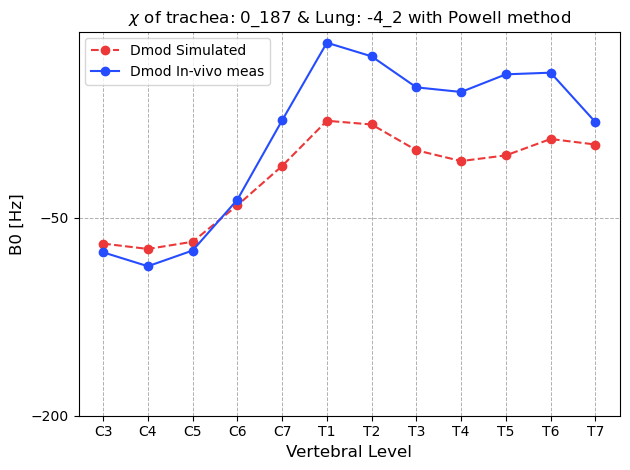

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #16
Chi for trachea: 0.1917888607183973
Chi for lungs: -4.2
For iteration #16 using -296.4733902599632
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_192_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_192_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_192_l_-4_2_Hz.csv

Total runtime; 9.589 seconds.

Difference:  286.5042055258569


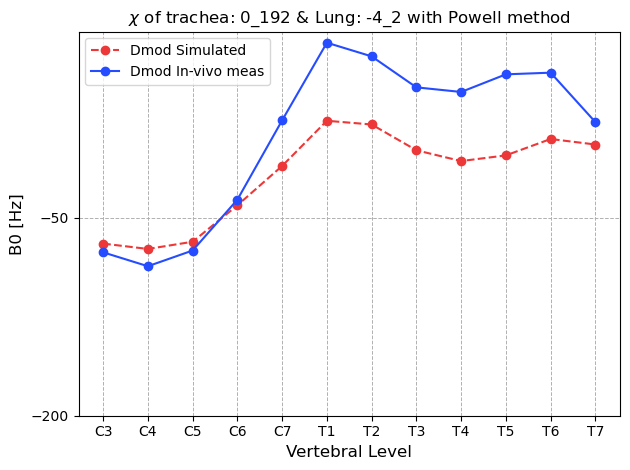

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #17
Chi for trachea: 0.19492523683760998
Chi for lungs: -4.2
For iteration #17 using -296.47331918145295
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_195_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_195_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_195_l_-4_2_Hz.csv

Total runtime; 9.475 seconds.

Difference:  286.50340029796166


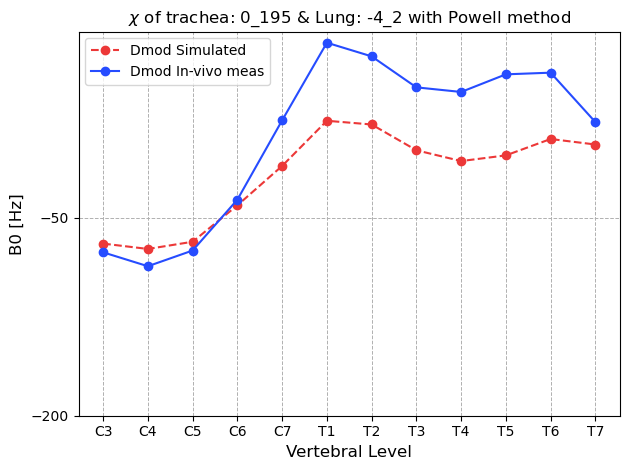

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #18
Chi for trachea: 0.19686362388078704
Chi for lungs: -4.2
For iteration #18 using -296.4732752525177
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_197_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_197_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_197_l_-4_2_Hz.csv

Total runtime; 9.376 seconds.

Difference:  286.50290265722


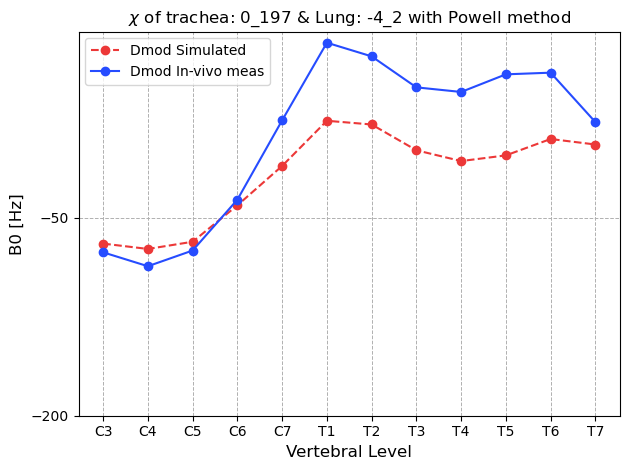

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #19
Chi for trachea: 0.19806161295682312
Chi for lungs: -4.2
For iteration #19 using -296.4732481029427
Metrics extracted successfully: 
--
Spinal Cord Toolbox (7.0)

sct_extract_metric -i E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_fms\test1_powell\sim_dmod_fm_tr_0_198_l_-4_2_Hz.nii.gz -f E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_198_l_-4_2_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\iter_metrics\test1_powell\metrics_sim_dmod_fm_tr_0_198_l_-4_2_Hz.csv

Total runtime; 9.668 seconds.

Difference:  286.5025951049987


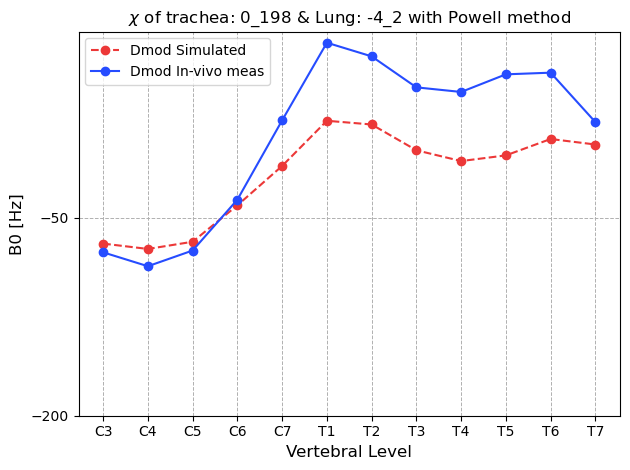

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #20
Chi for trachea: 0.19880201092396454
Chi for lungs: -4.2
For iteration #20 using -296.4732313235825


In [ ]:
# Set initial values, boundaries and run optimization
initial_values = [-2, -4.2] # Body should begin
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
bounds = [(-11, 0.2), (-5, 0.2)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_fms)
    
    result = optimize.minimize(f_simple_double_opt, initial_values, bounds = bounds, method = 'Powell')

    # Output the result
    print("Optimization result:", result)
    print("######## ############## ############### #############")

In [ ]:
chi_values_range = np.linspace(-1, 0.5, 100)

plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence Plot 1D for Chi Air")
plt.grid()
plt.show()

In [ ]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)
plt.plot(history_chi_lungs, marker='2', linestyle='--')
plt.plot(history_chi_trachea, marker='4', linestyle='-.')

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence pf Chi Trachea & Lungs")
plt.legend(["Lungs", "Trachea"])
plt.grid()
plt.show()

 # <span style="color:#D8C40D6A"> *Metrics!* </span> </br>
 Let's analyze how much we've improved after optimization

In [ ]:
worst_l2 = np.max(history)
print("Worst L2 norm: ", worst_l2)
best_l2 = np.min(history)
print("Best L2 norm: ", best_l2)

Worst L2 norm:  nan
Best L2 norm:  nan
